In [1]:
import os
from os.path import basename, join
import numpy as np
import pandas as pd
import torch
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:2" if torch.cuda.is_available() else "cpu"


In [2]:
def pad_sequence_to_max_length(sequence, max_length):
    # sequence shape: (Length, Dim)
    length, dim = sequence.shape
    if length < max_length:
        padding_amount = max_length - length
        padded_sequence = F.pad(sequence, (0, 0, 0, padding_amount))
    else:
        padded_sequence = sequence
    return padded_sequence

In [3]:
data_foler = "/home/ec2-user/klebsiella_embeddings"
host_embeddings_folder = "/home/ec2-user/klebsiella_embeddings/host_embeddings"
phage_embeddings_folder = "/home/ec2-user/klebsiella_embeddings/phage_embeddings"
positive_pairs_1 = "/home/ec2-user/klebsiella_embeddings/study1_pairs_positive.txt"
positive_pairs_2 = "/home/ec2-user/klebsiella_embeddings/study2_pairs_positive.txt"

In [4]:
df_pos1 = pd.read_csv(positive_pairs_1, sep = "\t")
df_pos2 = pd.read_csv(positive_pairs_2, sep = "\t")
df_pos = pd.concat([df_pos1, df_pos2])

In [5]:
bacteria = df_pos.bacterial_host.unique()
phage = df_pos.phage.unique()
all_possible_pairs = set(itertools.product(bacteria, phage))
existing_pairs = set(df_pos.itertuples(index=False, name=None))
negative_pairs = all_possible_pairs - existing_pairs
df_neg = pd.DataFrame(list(negative_pairs), columns=df_pos.columns)
df_neg = df_neg.sample(n=len(df_pos), random_state=42)

In [6]:
df_pos["label"] = 1.
df_neg["label"] = 0.
df_all = pd.concat([df_pos, df_neg]).drop_duplicates().sample(frac = 1., random_state=42)


In [7]:
host_embeddings_dict = {}
phage_embeddings_dict = {}
for he in os.listdir(host_embeddings_folder):
    full_path = join(host_embeddings_folder, he)
    host_embeddings_dict[he.split(".")[0]] = torch.load(full_path)
for pe in os.listdir(phage_embeddings_folder):
    full_path = join(phage_embeddings_folder, pe)
    phage_embeddings_dict[pe.split(".")[0]] = torch.load(full_path)

In [8]:
MAX_BACTERIA_LENGTH = 0
MAX_VIRAL_LENGTH = 0
for key, val in host_embeddings_dict.items():
    if val.shape[0] > MAX_BACTERIA_LENGTH:
        MAX_BACTERIA_LENGTH = val.shape[0]
for key, val in phage_embeddings_dict.items():
    if val.shape[0] > MAX_VIRAL_LENGTH:
        MAX_VIRAL_LENGTH = val.shape[0]

In [9]:
for key, val in host_embeddings_dict.items():
    host_embeddings_dict[key] = pad_sequence_to_max_length(val, MAX_BACTERIA_LENGTH)
for key, val in phage_embeddings_dict.items():
    phage_embeddings_dict[key] = pad_sequence_to_max_length(val, MAX_VIRAL_LENGTH)

In [10]:
df_all["bacterial_embedding"] = df_all["bacterial_host"].map(host_embeddings_dict)
df_all["viral_embedding"] = df_all["phage"].map(phage_embeddings_dict)
df_all = df_all.dropna()

In [11]:
bacteria_data = torch.stack(df_all.bacterial_embedding.tolist())
viral_data = torch.stack(df_all.viral_embedding.tolist())
label = torch.tensor(df_all.label.tolist())

In [12]:

class CNNResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super(CNNResidualBlock, self).__init__()
    self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn1 = nn.BatchNorm1d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
    self.bn2 = nn.BatchNorm1d(out_channels)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride*2, bias=False),
        nn.BatchNorm1d(out_channels)
      )

  def forward(self, x):
    residual = self.shortcut(x)
    # print(f"Residual shape: {residual.shape}")
    out = self.conv1(x)
    # print(f"Conv1 shape: {out.shape}")
    out = self.bn1(out)
    # print(f"BN1 shape: {out.shape}")
    out = F.relu(out)
    # print(f"ReLU shape: {out.shape}")
    out = self.conv2(out)
    # print(f"Conv2 shape: {out.shape}")
    out = self.bn2(out)
    # print(f"BN2 shape: {out.shape}")
    out += residual
    # print(f"Residual added shape: {out.shape}")
    out = F.relu(out)
    # print(f"Final ReLU shape: {out.shape}")
    return out

class BacteriaNN(nn.Module):
    def __init__(self, embedding_dim, output_dim, kernel_size, padding, avg_poolsize, embedding_reduction_factor, resblock_num, stride, dropout_rate = 0.2):
        super(BacteriaNN, self).__init__()
        self.conv1 = nn.Conv1d(embedding_dim, embedding_dim//embedding_reduction_factor, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(embedding_dim//embedding_reduction_factor)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        for i in range(resblock_num):
            setattr(self, f'resblock{i+1}', CNNResidualBlock(embedding_dim//embedding_reduction_factor, embedding_dim//embedding_reduction_factor, kernel_size=kernel_size, padding=padding, stride=stride))
        self.avgpool = nn.AdaptiveAvgPool1d(avg_poolsize)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(avg_poolsize*embedding_dim//embedding_reduction_factor, output_dim)
        self.resblock_num = resblock_num

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        # print(f"After maxpool: {x.shape}")
        for i in range(self.resblock_num):
            x = getattr(self, f'resblock{i+1}')(x)
            # print(f"After resblock{i+1}: {x.shape}")
        # print(f"After resblock4: {x.shape}")
        x = self.avgpool(x)
        # print(f"After avgpool: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"After view: {x.shape}")
        x = self.dropout(x)
        # print(f"After dropout: {x.shape}")
        x = self.fc(x)
        return x


In [13]:
class ViralNN(nn.Module):
    def __init__(self, embedding_dim, length, output_dim, hidden_dims=[128, 64], dropout_rate = 0.2):
        super(ViralNN, self).__init__()

        fc_input_dim = embedding_dim * length
        layers = []
        current_dim = fc_input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim

        layers.append(nn.Linear(current_dim, output_dim))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [46]:
# data_size = 1234
bacteria_max_seq_len = MAX_BACTERIA_LENGTH
viral_max_seq_len = MAX_VIRAL_LENGTH
embedding_dim = 4096 # use small to test, need to change to 4096
embedding_reduction_factor = 2
kernel_size = 5 # set to odd number smaller than embedding size
padding = (kernel_size - 1) // 2
stride = 1
avg_poolsize = 1
resblock_num = 2
output_dim = 256
dropout_rate = 0.2
hidden_dims = [embedding_dim//2, embedding_dim//4]

class PhINN(nn.Module):
    def __init__(self, bacteria_nn, viral_nn, embedding_dim, output_dim, skip_connection=False):
        super(PhINN, self).__init__()
        self.bacteria_nn = bacteria_nn
        self.viral_nn = viral_nn
        self.fc = nn.Linear(output_dim*2, output_dim)
        self.fc_skip0 = nn.Linear(embedding_dim*2, output_dim*2)
        self.fc_skip = nn.Linear(output_dim*4, output_dim)
        self.fc2 = nn.Linear(output_dim, 1)
        self.skip_connection = skip_connection
        self.bn = nn.BatchNorm1d(output_dim)

    def forward(self, bacteria_input, viral_input):
        bacteria_output = self.bacteria_nn(bacteria_input)
        viral_output = self.viral_nn(viral_input)

        combined_output = torch.cat((bacteria_output, viral_output), dim=1)
        if self.skip_connection:
            bacteria_output_skip = bacteria_input.sum(dim=1).squeeze()  # Shape: (batch_size, output_dim)
            viral_output_skip = bacteria_input.sum(dim=1).squeeze()
            combined_output_skip = torch.cat((bacteria_output_skip, viral_output_skip), dim=1)
            combined_output_skip = self.fc_skip0(combined_output_skip)
            combined_output = torch.cat((combined_output_skip, combined_output), dim = 1)
            output = self.fc_skip(combined_output)
        else:
            output = self.fc(combined_output)
        
        output = self.bn(output)
        output = nn.ReLU()(output)
        logits = self.fc2(output)
        probs = torch.sigmoid(logits)
        return probs




# Example input tensors
# bacteria_input = torch.randn(data_size, bacteria_max_seq_len, embedding_dim)
# viral_input = torch.randn(data_size, viral_max_seq_len, embedding_dim)
# example_labels = torch.randint(0, 2, (data_size,))

bacteria_input = bacteria_data
viral_input = viral_data
example_labels = label.reshape(-1,1)

In [47]:
from sklearn.model_selection import train_test_split

bacteria_train, bacteria_temp, viral_train, viral_temp, labels_train, labels_temp = train_test_split(
    bacteria_input, viral_input, example_labels, test_size=0.4, random_state=42
)

bacteria_val, bacteria_test, viral_val, viral_test, labels_val, labels_test = train_test_split(
    bacteria_temp, viral_temp, labels_temp, test_size=0.5, random_state=42
)

# Move data to the device (e.g., GPU if available)
bacteria_train, viral_train, labels_train = bacteria_train.to(device), viral_train.to(device), labels_train.to(device)
bacteria_val, viral_val, labels_val = bacteria_val.to(device), viral_val.to(device), labels_val.to(device)
bacteria_test, viral_test, labels_test = bacteria_test.to(device), viral_test.to(device), labels_test.to(device)


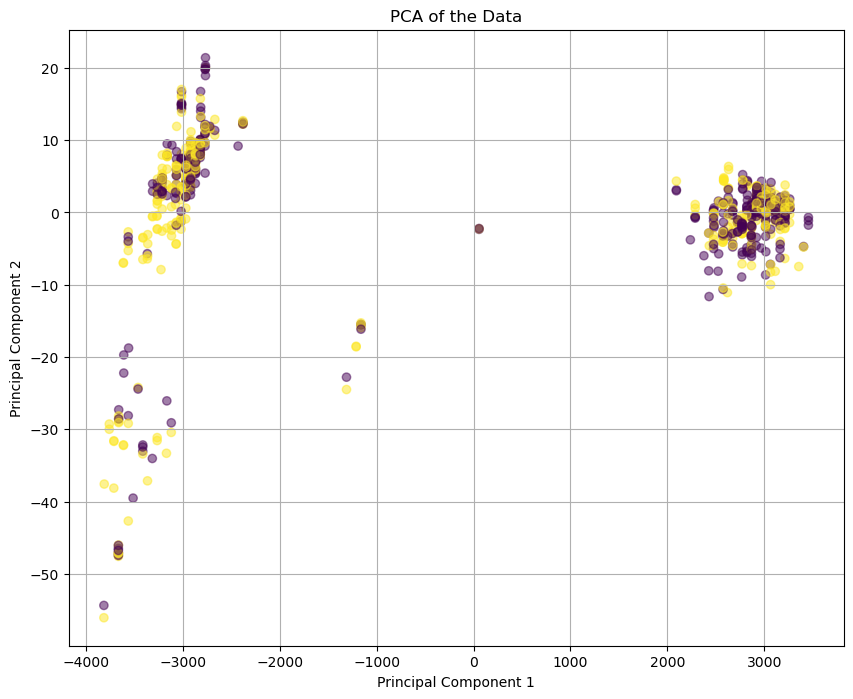

In [48]:
sum_embeddings = bacteria_input.sum(dim =1) + viral_input.sum(dim =1)
pca = PCA(n_components=2)  # Reduce to 2 dimensions
data_pca = pca.fit_transform(sum_embeddings)

# Step 3: Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, c = label)
plt.title('PCA of the Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
bacteria_nn = BacteriaNN(embedding_dim = embedding_dim, kernel_size = kernel_size, padding = padding, stride = stride, avg_poolsize = avg_poolsize, resblock_num = resblock_num, embedding_reduction_factor = embedding_reduction_factor, output_dim = output_dim)
viral_nn = ViralNN(embedding_dim = embedding_dim, length=viral_max_seq_len, output_dim=output_dim, hidden_dims=hidden_dims, dropout_rate = dropout_rate)

# Create an instance of PhINN
phinn_model = PhINN(bacteria_nn, viral_nn, output_dim=output_dim, embedding_dim=embedding_dim, skip_connection = True).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(phinn_model.parameters(), lr=0.0001)

num_epochs = 100
batch_size = 32
train_size = len(bacteria_train)
val_size = len(bacteria_val)
test_size = len(bacteria_test)
data_size = len(bacteria_input)
train_accs = []
val_accs = []
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training phase
    phinn_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    num_train_batches = (train_size + batch_size - 1) // batch_size

    for i in tqdm(range(0, train_size, batch_size)):
        # Get training batch
        bacteria_batch = bacteria_train[i:i+batch_size]
        viral_batch = viral_train[i:i+batch_size]
        labels_batch = labels_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = phinn_model(bacteria_batch, viral_batch)

        # Compute the loss
        loss = criterion(outputs, labels_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item()

        # Calculate accuracy
        predicted_train = (outputs.squeeze() > 0.5).float() 
        # print(predicted_train.shape,labels_batch.shape)
        # print((predicted_train == labels_batch.squeeze()).sum().item())

        correct_train += (predicted_train == labels_batch.squeeze()).sum().item()
        total_train += labels_batch.size(0)

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = train_loss / num_train_batches
    train_accuracy = correct_train / total_train
    train_accs.append(train_accuracy)
    train_losses.append(avg_train_loss)

    # Validation phase (evaluation on validation set)
    phinn_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    num_val_batches = (val_size + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in range(0, val_size, batch_size):
            # Get validation batch
            bacteria_batch = bacteria_val[i:i+batch_size]
            viral_batch = viral_val[i:i+batch_size]
            labels_batch = labels_val[i:i+batch_size]

            # Forward pass
            outputs = phinn_model(bacteria_batch, viral_batch)

            # Compute the loss
            loss = criterion(outputs, labels_batch)

            # Accumulate loss
            val_loss += loss.item()

            # Calculate accuracy
            predicted_val = (outputs.squeeze() > 0.5).float()  # Threshold at 0.5
            correct_val += (predicted_val == labels_batch.squeeze()).sum().item()
            total_val += labels_batch.size(0)

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / num_val_batches
    val_accuracy = correct_val / total_val
    val_accs.append(val_accuracy)
    val_losses.append(avg_val_loss)

    # Print the average loss and accuracy for training and validation set
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# After training, you can later evaluate the model on the test set:
phinn_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for i in range(0, test_size, batch_size):
        # Get test batch
        bacteria_batch = bacteria_test[i:i+batch_size]
        viral_batch = viral_test[i:i+batch_size]
        labels_batch = labels_test[i:i+batch_size]

        # Forward pass
        outputs = phinn_model(bacteria_batch, viral_batch)
        # Compute the loss
        loss = criterion(outputs, labels_batch)

        # Accumulate loss
        test_loss += loss.item()

        # Calculate accuracy
        predicted_test = (outputs.squeeze() > 0.5).float()
        correct_test += (predicted_test == labels_batch.squeeze()).sum().item()
        total_test += labels_batch.size(0)

# Calculate final test loss and accuracy
avg_test_loss = test_loss / (test_size // batch_size)
test_accuracy = correct_test / total_test

# Print the test loss and accuracy
print(f"Final Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

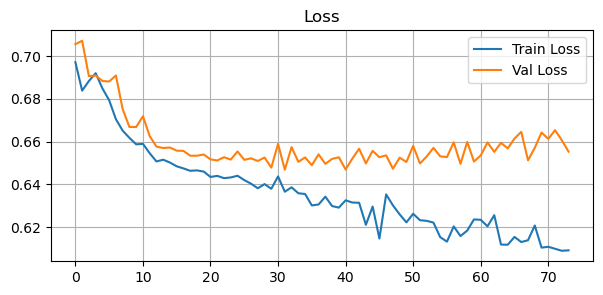

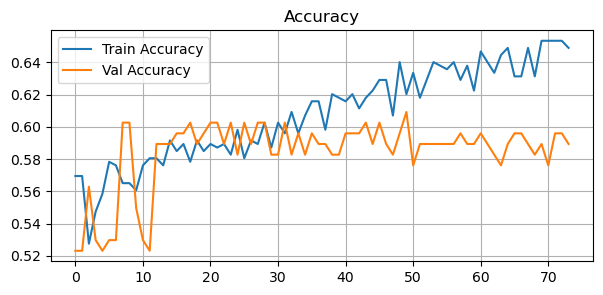

In [51]:
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(train_accs, label = "Train Accuracy")
plt.plot(val_accs, label = "Val Accuracy")
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()